In [123]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn.functional as F
from skimage.segmentation import mark_boundaries, slic
from PIL import Image
from lime import lime_image
import shap
import os
from torch.utils.data import Subset
from pathlib import Path

In [124]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [125]:
train_dataset = ImageFolder("../data/teeth_cropped/train", transform=transform)
val_dataset = ImageFolder("../data/teeth_cropped/val", transform=transform)
test_dataset = ImageFolder("../data/teeth_cropped/test", transform=transform)

In [126]:
print(train_dataset.class_to_idx)

{'caries': 0, 'healthy': 1}


In [127]:
targets = [label for _, label in train_dataset]
class_sample_count = np.array([len(np.where(np.array(targets) == t)[0]) for t in np.unique(targets)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in targets])
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [128]:
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16)

In [129]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
target_layers = [model.layer4[-1]]

In [130]:
device = torch.accelerator.current_accelerator().type
device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [131]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [132]:
for epoch in range(6):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.3810
Epoch 2, Loss: 0.2428
Epoch 3, Loss: 0.1283
Epoch 4, Loss: 0.0974
Epoch 5, Loss: 0.2084
Epoch 6, Loss: 0.1897


### Validation accuracy

In [133]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

      caries       1.00      1.00      1.00        10
     healthy       1.00      1.00      1.00         7

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



### Test accuracy

In [134]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
correct / total

1.0

### **Apply Grad-CAM**

In [169]:
img_path = "../data/teeth/test/healthy/47.jpg"
original_image = Image.open(img_path).convert("RGB")
rgb_img_resized = original_image.resize((224, 224))
input_tensor = transform(rgb_img_resized).unsqueeze(0)
input_tensor = input_tensor.to(device)
rgb_img = np.array(rgb_img_resized).astype(np.float32) / 255.0

In [170]:
model.eval()

outputs = model(input_tensor)
_, predicted_class = outputs.max(1)
class_idx = predicted_class.item()
class_label = train_dataset.classes[class_idx] 

target_layers = [model.layer4[-1]]

targets = [ClassifierOutputTarget(class_idx)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]  # remove batch dim

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

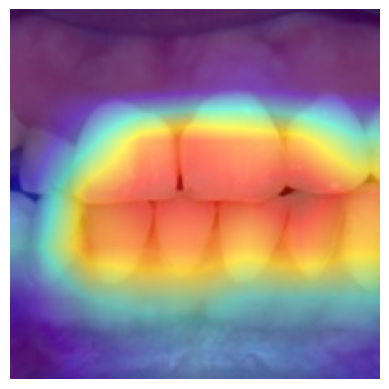

In [171]:
plt.imshow(visualization)
#plt.title(f"GradCAM Explanation {class_label}", fontsize = 18)
plt.axis('off')
plt.savefig("../outputs/grad_cam_healthy.pdf")
plt.show()

### Apply LIME

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_path = "../data/teeth/test/healthy/47.jpg"
img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0).to(device)
input_tensor = input_tensor.to(device)

In [152]:
def batch_predict(images):
    model.eval()
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images], dim=0).to(device)
    with torch.no_grad():
        outputs = model(batch)
        return outputs.softmax(1).cpu().numpy()
    
input_tensor = preprocess(img).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor.to(device))
    predicted_class = output.argmax(dim=1).item()

In [157]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(img),
    batch_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=3,
    hide_rest=False
)

100%|██████████| 1000/1000 [00:05<00:00, 183.59it/s]


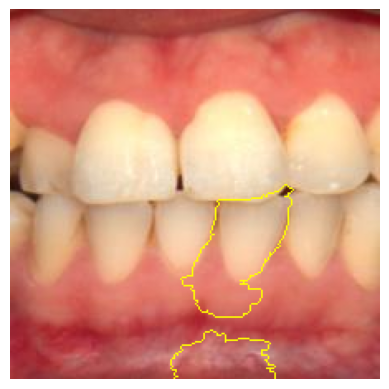

In [158]:
plt.imshow(mark_boundaries(temp / 255.0, mask, color=(1, 1, 0)))
#plt.title(f"LIME Explanation", fontsize= 18)
plt.axis('off')
plt.savefig("../outputs/lime_healthy.pdf")
plt.show()

### Apply SHAP

see dedicated notebook

### Vector graphic comparison

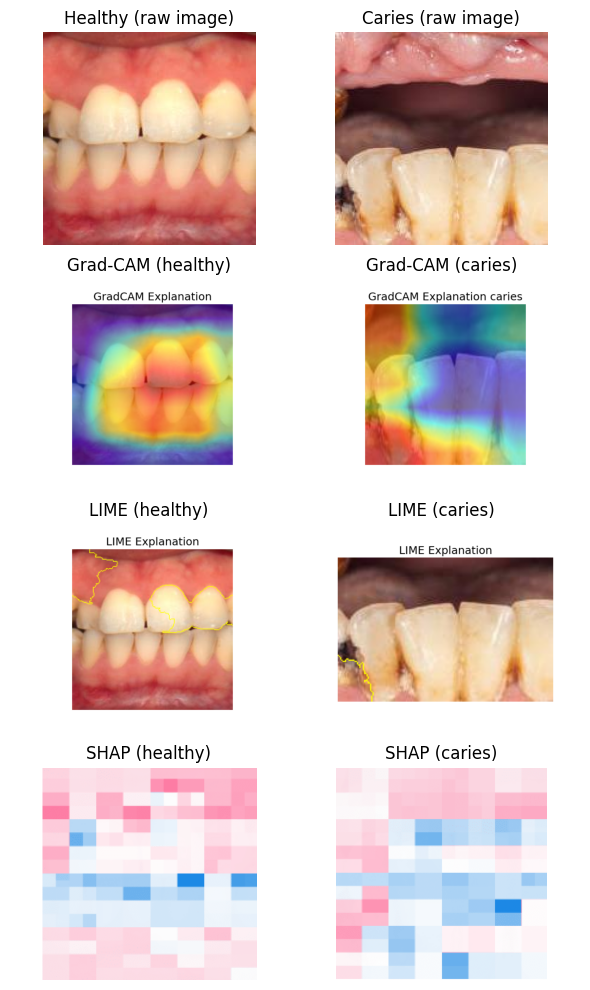

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images = [
    ["../data/teeth/test/healthy/47.jpg", '../data/teeth/test/caries/90.jpg'],
    ['../outputs/grad_cam_healthy.png', '../outputs/grad_cam_caries.png'],
    ['../outputs/lime_healthy.png', '../outputs/lime_caries.png'],
    ['../outputs/shap_healthy-1.png', '../outputs/shap_caries.png']
]

titles = [
    ['Healthy (raw image)', 'Caries (raw image)'],
    ['Grad-CAM (healthy)', 'Grad-CAM (caries)'],
    ['LIME (healthy)', 'LIME (caries)'],
    ['SHAP (healthy)', 'SHAP (caries)']
]

fig, axs = plt.subplots(4, 2, figsize=(6, 10))

for row in range(4):
    for col in range(2):
        img_path = images[row][col]
        img = mpimg.imread(img_path)
        axs[row, col].imshow(img)
        axs[row, col].set_title(titles[row][col], fontsize=12)
        axs[row, col].axis('off')

plt.tight_layout()
# Optional: save
plt.savefig("../outputs/caries_grid.pdf", bbox_inches='tight')
plt.show()